In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import pandas as pd

## Unknown coin: Bayes vs optimal?

In [18]:
def dyn_prog(T, th=None):
    S = np.arange(T+1, dtype=np.float32)
    V = [np.zeros(t+1, dtype=np.float32) for t in range(T+2)]
    if th is None:
        for t in reversed(range(1, T+1)):
            s = S[:t+1]
            a = (t - s + 1) / (t + 2)
            b = (s + 1) / (t + 2)
            V[t] = np.maximum(s/t, a*V[t+1][:-1] + b*V[t+1][1:])
    else:
        a, b = 1 - th, th
        for t in reversed(range(1, T+1)):
            s = S[:t+1]
            V[t] = np.maximum(s/t, a*V[t+1][:-1] + b*V[t+1][1:])
    th = th if th is not None else 0.5
    V[0][0] = (1-th)*V[1][0] + th*V[1][1]
    del V[-1]
    return V

In [19]:
def eval_pol(V, th, N, n_games, n_evals):
    av_rew = []
    for _ in range(n_evals):
        # Generate random games
        r = np.random.choice(2, size=(n_games, N), p=(1-th, th))
        s = r.cumsum(axis=1)
        # Find stopping times for given games
        stop_idx = np.zeros((n_games, N), dtype=np.bool)
        for n in range(1, N+1):
            stop_idx[:, n-1] = s[:, n-1] / n >= V[n][s[:, n-1]]
        # Set t_stop = N for games that did not terminate
        stop_time = stop_idx.argmax(axis=1) + 1
        games = np.arange(n_games)
        stop_time[np.nonzero(~stop_idx[games, stop_time - 1])] = N
        # Compute average reward over games
        reward = s[games, stop_time - 1] / stop_time
        av_rew.append(np.mean(reward))
    return av_rew

In [20]:
def test(v, th_all, n_steps, n_games, n_evals):
    means, stds = [], []
    for th in th_all:
        av_rew = eval_pol(v, th, n_steps, n_games, n_evals)
        means.append(np.mean(av_rew))
        stds.append(np.std(av_rew))
    return np.array(means), np.array(stds)

In [21]:
T = 10000
params = dict(
    n_steps=1000,
    n_games=100,
    n_evals=100
)
n_th = 20
th_train = (0.2, 0.5, 0.8)
th_test = np.linspace(0, 1, n_th)

coin-independent policy: 0.6643007462814828
trained on p=0.2 coin: 0.6555838462648302
trained on p=0.5 coin: 0.663507001867137
trained on p=0.8 coin: 0.6581830456782825


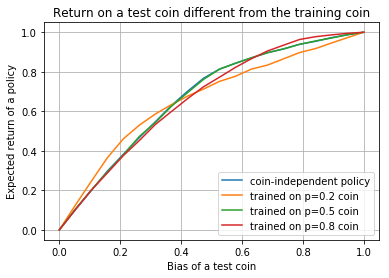

In [24]:
fig, ax = plt.subplots()

# Coin-independent policy
mean_v, std_v = test(dyn_prog(T), th_test, **params)
ax.plot(th_test, mean_v, label='coin-independent policy')
print(f'coin-independent policy: {np.mean(mean_v)}')

# Policy optimal for a certain coin
for th in th_train:
    v_th = dyn_prog(T, th)
    mean_vth, std_vth = test(v_th, th_test, **params)
    ax.plot(th_test, mean_vth, label=f'trained on p={th} coin')
    print(f'trained on p={th} coin: {np.mean(mean_vth)}')

ax.set_title('Return on a test coin different from the training coin')
ax.set_xlabel('Bias of a test coin')
ax.set_ylabel('Expected return of a policy')
ax.legend()
ax.grid()

In [25]:
fig.savefig('return_vs_bias.png', dpi=200)

## Dynamic programming solution and optimal policy

In [100]:
N = 10000
V = [np.zeros(n+1, dtype=np.float32) for n in range(N+2)]
for n in reversed(range(1, N+1)):
    rew_now = np.linspace(-1, 1, n+1, dtype=np.float32)
    v_next = 0.5 * (V[n+1][:-1] + V[n+1][1:])
    V[n] = np.maximum(rew_now, v_next)
V[0][0] = 0.5 * (1 + V[1][0])
del V[-1]
print(f'{N}: {V[0][0]}')

10000: 0.5857622623443604


In [70]:
N = 1000
n_runs = 50
n_iter = 1000
av_rets = []
for _ in range(n_runs):
    x = np.random.choice(2, size=(n_iter, N))
    idx = x.cumsum(axis=1)
    y = np.cumsum(2*x - 1, axis=1) / np.arange(1, N+1)

    idx_opt = []
    for n in range(1, N+1):
        idx_opt.append([y[:, n-1] >= V[n][idx[:, n-1]]])
    idx_opt = np.concatenate(idx_opt).T

    opt_col = idx_opt.argmax(axis=1)
    rows_all = np.arange(n_iter)
    opt_col[np.nonzero(~idx_opt[rows_all, opt_col])] = -1
    rets = y[rows_all, opt_col]

    av_rets.append(rets.mean())

In [71]:
mean = np.mean(av_rets)
std = np.std(av_rets)
print(f'{mean:{5}.{4}} in ({mean-std:{5}.{4}}, {mean+std:{5}.{4}})')

0.5783 in (0.5657, 0.5909)


## Plot stopping time vs return

In [2]:
def dyn_prog(N):
    V = [np.zeros(n+1, dtype=np.float32) for n in range(N+2)]
    for n in reversed(range(1, N+1)):
        rew_now = np.linspace(-1, 1, n+1, dtype=np.float32)
        v_next = 0.5 * (V[n+1][:-1] + V[n+1][1:])
        V[n] = np.maximum(rew_now, v_next)
    V[0][0] = 0.5 * (1 + V[1][0])
    del V[-1]
    return V

In [3]:
N = 10000
V = dyn_prog(N)

In [4]:
T = 10000
xt_pairs = []
for t in range(1, T+1):
    r = np.linspace(-1, 1, t+1, dtype=np.float32)
    v = V[t]
    x = r[r >= v]
    xt_pairs.append(np.c_[x, t*np.ones_like(x)])

In [5]:
df = pd.DataFrame(np.vstack(xt_pairs), columns=('return', 'time'))
xt_all = df.groupby('return').min().reset_index()
tx_all = xt_all.sort_values(['time', 'return'])

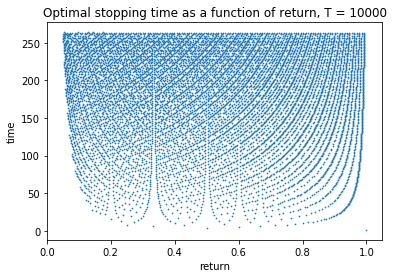

In [16]:
ax = tx_all[:T].plot.scatter('return', 'time', s=0.5)
ax.set_title(f'Optimal stopping time as a function of return, T = {N}')
fig = ax.get_figure()

In [17]:
fig.savefig('opt_stop_times.png', dpi=200)

## Study $V(x, t, T)$ when $T \to \infty$

In [2]:
def dyn_prog(N):
    V = [np.zeros(n+1, dtype=np.float32) for n in range(N+2)]
    for n in reversed(range(1, N+1)):
        rew_now = np.linspace(-1, 1, n+1, dtype=np.float32)
        v_next = 0.5 * (V[n+1][:-1] + V[n+1][1:])
        V[n] = np.maximum(rew_now, v_next)
    V[0][0] = 0.5 * (1 + V[1][0])
    del V[-1]
    return V

In [3]:
# Do dynamic programming with various horizons
N_all = (10000, 50000, 100000)
V_all = [dyn_prog(N) for N in N_all]

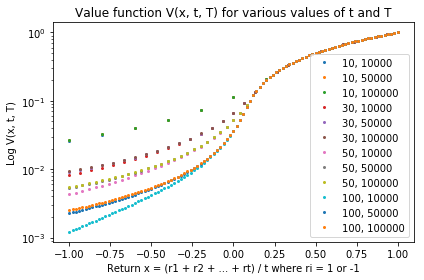

In [108]:
# Plot V(x, t, T) for various t and T
n_all = 10, 30, 50, 100
fig, ax = plt.subplots()
for n in n_all:
    lines = [ax.semilogy(np.linspace(-1, 1, V[n].size), V[n],
                     label=f'{n}, {N_all[i]}', marker='o', markersize='2.0', linestyle='')
             for i, V in enumerate(V_all)]
ax.set_title('Value function V(x, t, T) for various values of t and T')
ax.set_xlabel('Return x = (r1 + r2 + ... + rt) / t where ri = 1 or -1')
ax.set_ylabel('Log V(x, t, T)')
ax.legend()
fig.tight_layout()

## Fit softmax

      fun: 5.218645800125955
 hess_inv: array([[ 6.15014733e+01,  7.34071307e+00, -1.23917715e+00,
         1.60002247e+00,  8.85038821e-01],
       [ 7.34071307e+00,  1.04071841e+00, -2.27766218e-01,
         3.50838112e-02,  7.93033813e-02],
       [-1.23917715e+00, -2.27766218e-01,  1.47168013e-01,
        -2.56322417e-02, -2.52522311e-03],
       [ 1.60002247e+00,  3.50838112e-02, -2.56322417e-02,
         2.74209284e-01,  5.09540610e-02],
       [ 8.85038821e-01,  7.93033813e-02, -2.52522311e-03,
         5.09540610e-02,  1.90979803e-02]])
      jac: array([ 4.77256318e-10, -2.37682052e-09, -7.28808736e-10,  1.77723125e-09,
       -1.35564591e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 74
      nit: 54
     njev: 73
   status: 2
  success: False
        x: array([-91.21474025, -13.96901332, -14.17514496,   5.18429706,
        -6.64592799])


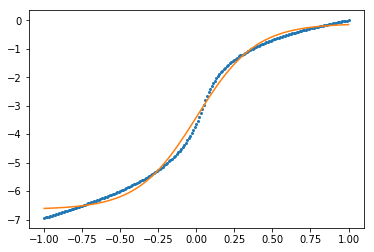

In [192]:
import autograd.numpy as np
from autograd import grad

n = 200
y = V_all[-1][n]
x = np.linspace(-1, 1, y.size)
# f = lambda th, x: np.log(th[0] + th[1] * np.exp(th[2] * x))
f = lambda th, x: th[0] / (th[1] + th[2] * np.exp(-th[3] * x)) + th[4]
J = lambda th: np.sum((np.log(y) - f(th, x)) ** 2)

th0 = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
th0 += 1e-2 * np.random.randn(th0.size)
sol = minimize(J, th0, jac=grad(J), tol=1e-8)

print(sol)
th_opt = sol.x
F = lambda x: f(th_opt, x)

fig, ax = plt.subplots()
ax.plot(x, np.log(y), marker='o', markersize='2.0', linestyle='')
ax.plot(x, F(x))

## Plot value function

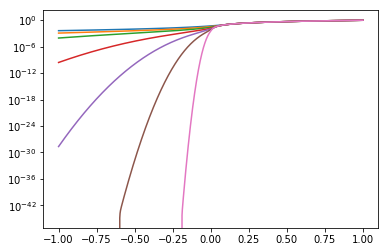

In [101]:
n_all = (50, 100, 200, 500, 1000, 2000, 5000)
fig, ax = plt.subplots()
for n in n_all:
    ax.semilogy(np.linspace(-1, 1, V[n].size), V[n])